<h1 style="color: #492c68;">01 | PREPROCESSING</h1>

<h2 style="color: #327a81;">Libraries</h2>

In [1]:
## Basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import chardet

## Settings

pd.set_option('display.max_columns', None) # display all columns
import warnings
warnings.filterwarnings('ignore') # ignore warnings

<h2 style="color: #327a81;">Data Standardization</h2>

In [2]:
with open("26014.csv", "rb") as f:
    result = chardet.detect(f.read())
    encode = result["encoding"]

In [3]:
data = pd.read_csv("26014.csv", encoding=encode, sep="\t")

In [4]:
data

,Tipo de Delito: Nivel 1,Tipo de Delito: Nivel 2,Tipo de Delito: Nivel 3,Tipo de Delito: Nivel 4,Nacionalidad,Periodo,Total
0,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2022,800.0
1,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2021,876.0
2,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2020,786.0
3,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2019,847.0
4,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2018,837.0
...,...,...,...,...,...,...,...
625,A Delitos,22 Contra el orden público,NaN,NaN,De Oceanía,2017,2.0
626,A Delitos,22 Contra el orden público,NaN,NaN,De Oceanía,2016,4.0
627,A Delitos,22 Contra el orden público,NaN,NaN,De Oceanía,2015,1.0
628,A Delitos,22 Contra el orden público,NaN,NaN,De Oceanía,2014,7.0


In [5]:
df = data.copy()

In [6]:
# Changing all columns names to lowercase for better usability

df.columns = map(str.lower, df.columns)

<h3 style="color: #60b671;">Dataset shape & types</h3>

In [7]:
df.shape

(630, 7)

In [8]:
df.dtypes

tipo de delito: nivel 1     object
tipo de delito: nivel 2     object
tipo de delito: nivel 3     object
tipo de delito: nivel 4    float64
nacionalidad                object
periodo                      int64
total                      float64
dtype: object

<h3 style="color: #60b671;">Dealing with numerical types: floats bigger than 1K in "total"</h3>

- "total" field is recognised as float. It has interpreted x>1000 values as decimals instead of thounsads. We need to fix it

In [9]:
# Create a function that fixes thousands instead of decimals

def total_fixer(value):
    if pd.notna(value) and value != int(value):
        return value * 1000
    return value

In [10]:
df["total"] = df["total"].apply(total_fixer)

In [11]:
# Turn "total" type into integer, so it will be leaner. For that we need to deal with total nulls
#After dealing with nulls, let's convert all to int

df["total"] = df["total"].fillna(0)
df["total"] = df["total"].astype(int)

In [12]:
df["total"].head(10)

0     800
1     876
2     786
3     847
4     837
5     925
6    1028
7    1071
8    1012
9    1096
Name: total, dtype: int32

<h3 style="color: #60b671;">Dealing with nulls</h3>

In [13]:
df.isnull().sum()

tipo de delito: nivel 1      0
tipo de delito: nivel 2      0
tipo de delito: nivel 3    360
tipo de delito: nivel 4    630
nacionalidad                 0
periodo                      0
total                        0
dtype: int64

- crime type fields causes the nulls because of the specific sublevels, so we will make a new column to have only one variable for the type of crime

In [14]:
crimes = df.iloc[:, [0, 1, 2, 3]]

In [15]:
crimes.head(1)

,tipo de delito: nivel 1,tipo de delito: nivel 2,tipo de delito: nivel 3,tipo de delito: nivel 4
0,A Delitos,1 Homicidio y sus formas,NaN,NaN


In [16]:
# column 0 is irrelevant, so we drop it

crimes = crimes.drop(columns="tipo de delito: nivel 1")

In [17]:
# It will be better if we rename the crime levels for a better usability

crimes = crimes.rename(columns={"tipo de delito: nivel 2":"n_2",
                      "tipo de delito: nivel 3": "n_3", "tipo de delito: nivel 4":"n_4"})

In [18]:
# Use iterrows to fill the new list, this will be the new column without nulls

tipo_delito = []

for index, row in crimes.iterrows():
    if pd.notna(row["n_3"]):
        tipo_delito.append(row["n_3"])
    elif pd. notna(row["n_4"]):
        tipo_delito.append(row["n_4"])
    else:
        tipo_delito.append(row["n_2"])

In [19]:
# Erase the epigraph number to clean the values with a list comprehension

tipo_delito = [string.split(" ", 1)[1] for string in tipo_delito]

In [20]:
df.drop(columns=df.columns[[0, 1, 2, 3]], inplace=True)

In [21]:
df.insert(0, "tipo_delito", tipo_delito)

In [22]:
# After dealing with crime types, Let's check again for nulls

df.isnull().sum()

tipo_delito     0
nacionalidad    0
periodo         0
total           0
dtype: int64

In [23]:
# And check how crimes look at the end

df["tipo_delito"].value_counts()

tipo_delito
Homicidio y sus formas           90
Lesiones                         90
Hurtos                           90
Robos                            90
Daños                            90
Contra la seguridad colectiva    90
Contra el orden público          90
Name: count, dtype: int64

<h3 style="color: #60b671;">Extra wrangling: simplifying confusing fields</h3>

In [24]:
# Europe area could be difficult to understand because of its segmentation, so it will be better if we reunite all in one

df["nacionalidad"].value_counts()

nacionalidad
Española                           70
País de la UE28 sin España         70
País de la UE27_2020 sin España    70
País de Europa menos UE28          70
País de Europa menos UE27_2020     70
De Africa                          70
De América                         70
De Asia                            70
De Oceanía                         70
Name: count, dtype: int64

In [25]:
# Use a mapping to rename all Europe divisions in only one

mapping = {
    "País de la UE28 sin España": "De Europa",
    "País de la UE27_2020 sin España": "De Europa",
    "País de Europa menos UE28": "De Europa",
    "País de Europa menos UE27_2020": "De Europa"
}

In [26]:
df["nacionalidad"] = df["nacionalidad"].replace(mapping)

In [27]:
# And finally, group up those variables to sum their values

columns_group = df.groupby(["tipo_delito", "nacionalidad", "periodo"])
df = columns_group["total"].sum().reset_index()

In [28]:
# Check once more "nacionalidad" to see how it end

df["nacionalidad"].value_counts()

nacionalidad
De Africa     70
De América    70
De Asia       70
De Europa     70
De Oceanía    70
Española      70
Name: count, dtype: int64

<h3 style="color: #60b671;">Clearing the dataset: dropping "De Oceanía" and "De Asia"</h3>

- Nacionalities "De Oceanía" and "De Asia" have a low percentage of crimes (less than 1% each one) that doensn't affect in statistics, so it will be better if we drop these rows from the dataset

In [29]:
df = df[(df["nacionalidad"] != "De Oceanía") & (df["nacionalidad"] != "De Asia")]

<h3 style="color: #60b671;">Dataframe final glance</h3>

In [30]:
print(df.sample(20))

                       tipo_delito nacionalidad  periodo  total
50         Contra el orden público     Española     2013   9131
120                          Daños    De Africa     2013    196
130                          Daños   De América     2013    181
234         Homicidio y sus formas     Española     2017    925
217         Homicidio y sus formas    De Europa     2020     95
135                          Daños   De América     2018    468
398                          Robos    De Europa     2021   1871
374                          Robos   De América     2017   1104
238         Homicidio y sus formas     Española     2021    876
118  Contra la seguridad colectiva     Española     2021  83392
291                         Hurtos     Española     2014   8020
64   Contra la seguridad colectiva    De Africa     2017   4703
216         Homicidio y sus formas    De Europa     2019    112
334                       Lesiones    De Europa     2017   5075
252                         Hurtos   De 

<h1 style="color: #492c68;">02 | EDA: Crime by Origin</h1>

<h2 style="color: #327a81;">Crime types analysis</h2>

- First at all, we define a function that helps us to filter our df by crime type

In [31]:
def crime_type_filter(value):
    df_delito = df[df["tipo_delito"] == value]
    return df_delito    

In [32]:
# Now we can segment the data in crime type variables

orden_publico = crime_type_filter("Contra el orden público")
seguridad_colectiva = crime_type_filter("Contra la seguridad colectiva")
daños = crime_type_filter("Daños")
homicidios = crime_type_filter("Homicidio y sus formas")
hurtos = crime_type_filter("Hurtos")
lesiones = crime_type_filter("Lesiones")
robos = crime_type_filter("Robos")

<h2 style="color: #327a81;">Type: Against Public Order</h2>

<h3 style="color: #60b671;">Decade Numbers and Percetage</h3>

In [33]:
orden_publico_general = orden_publico.groupby("nacionalidad")["total"].sum().sort_values(ascending=False).reset_index()

In [34]:
orden_publico_general

,nacionalidad,total
0,Española,103221
1,De Africa,15294
2,De Europa,14700
3,De América,12485


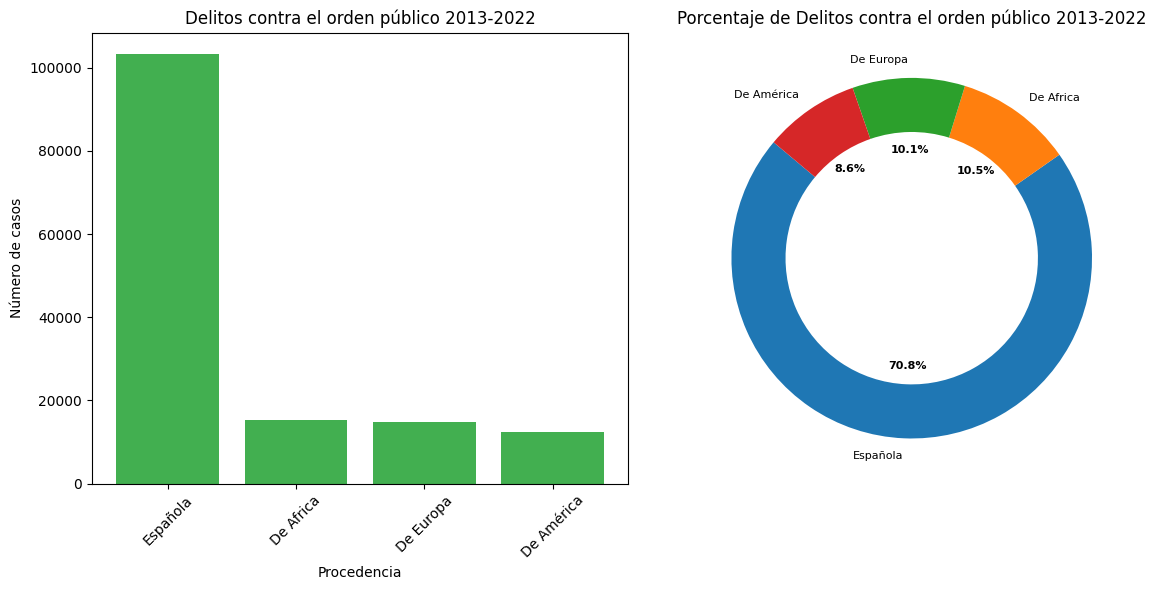

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(orden_publico_general["nacionalidad"], orden_publico_general["total"], color="#42af50")
axes[0].set_xlabel("Procedencia")
axes[0].set_ylabel("Número de casos")
axes[0].set_title("Delitos contra el orden público 2013-2022")
axes[0].tick_params(axis='x', rotation=45)

orden_publico_general["porcentaje"] = round(orden_publico_general["total"] / orden_publico_general["total"].sum() * 100, 2)

wedges, texts, autotexts = axes[1].pie(orden_publico_general["porcentaje"], labels=orden_publico_general["nacionalidad"], 
                                       autopct="%1.1f%%", startangle=140, wedgeprops=dict(width=0.3))
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)
axes[1].set_title("Porcentaje de Delitos contra el orden público 2013-2022")

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Evolution in the last 10 years</h3>

In [36]:
orden_publico.head(1)

,tipo_delito,nacionalidad,periodo,total
0,Contra el orden público,De Africa,2013,1218


In [37]:
orden_publico["nacionalidad"].unique()

array(['De Africa', 'De América', 'De Europa', 'Española'], dtype=object)

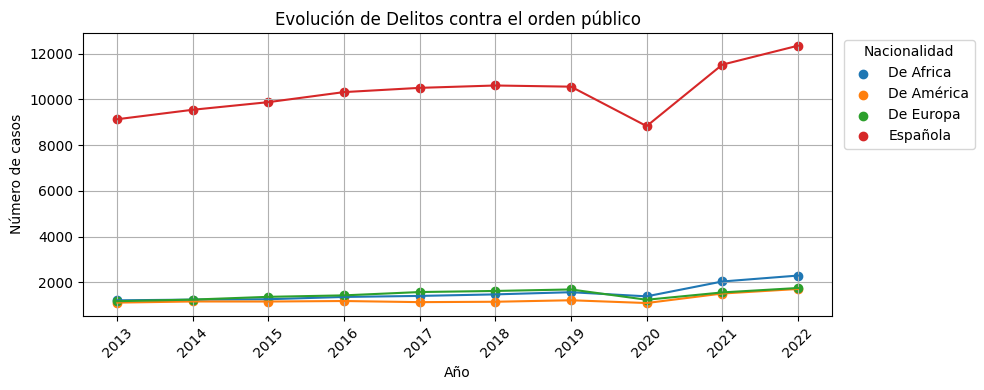

In [38]:
plt.figure(figsize=(10,4))
nacionalidades = orden_publico["nacionalidad"].unique()

for i, nacionalidad in enumerate(nacionalidades):
    subset = orden_publico[orden_publico["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["total"], label= nacionalidad)
    plt.plot(subset["periodo"], subset["total"])
    
plt.xticks(range(2013,2023), rotation= 45)
    
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.title("Evolución de Delitos contra el orden público")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Percentage of crime growth by year</h3>

In [39]:
orden_publico["porcentaje_crecimiento"] = round(orden_publico.groupby("nacionalidad")["total"].pct_change()*100,2)
orden_publico["porcentaje_crecimiento"].fillna(0, inplace=True)

In [40]:
# Calculate the average percentage growth by origin in the last decade

orden_publico_avg_pct = orden_publico.groupby("nacionalidad")["porcentaje_crecimiento"].mean()
orden_publico_avg_pct

nacionalidad
De Africa     7.408
De América    5.014
De Europa     4.898
Española      3.602
Name: porcentaje_crecimiento, dtype: float64

In [41]:
# Percentage Average Standard deviation

round(orden_publico_avg_pct.std(), 2)

1.59

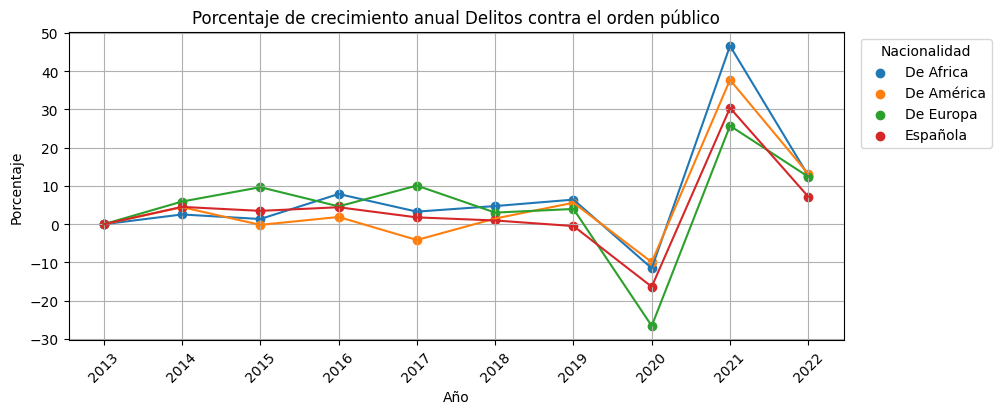

In [42]:
plt.figure(figsize=(10,4))

for nacionalidad in nacionalidades:
    subset = orden_publico[orden_publico["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["porcentaje_crecimiento"], marker="o", label= nacionalidad)
    plt.plot(subset["periodo"], subset["porcentaje_crecimiento"])
    
plt.xticks(range(2013,2023), rotation= 45)

plt.xlabel("Año")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de crecimiento anual Delitos contra el orden público")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

<h2 style="color: #327a81;">Type: Against Collective Security</h2>

- Find an error in one "total" value that shows a weird result on the time evolution plot. So let's correct it.

In [43]:
print(seguridad_colectiva.loc[113, "total"])
print(seguridad_colectiva.loc[114, "total"])
print(seguridad_colectiva.loc[115, "total"])

76085
76
77105


-  As we can see it above, the value on index 114 should be 76k aprox. It will be better if we replace this value with the average of the other two

In [44]:
value_113 = seguridad_colectiva.loc[113, "total"]
value_115 = seguridad_colectiva.loc[115, "total"]
value_114 = (value_113 + value_115) // 2

seguridad_colectiva.loc[114, "total"] = value_114

<h3 style="color: #60b671;">Decade Numbers and Percetage</h3>

In [45]:
seguridad_colectiva_general = seguridad_colectiva.groupby("nacionalidad")["total"].sum().sort_values(ascending=False).reset_index()

In [46]:
seguridad_colectiva_general

,nacionalidad,total
0,Española,790458
1,De América,105449
2,De Europa,82864
3,De Africa,53304


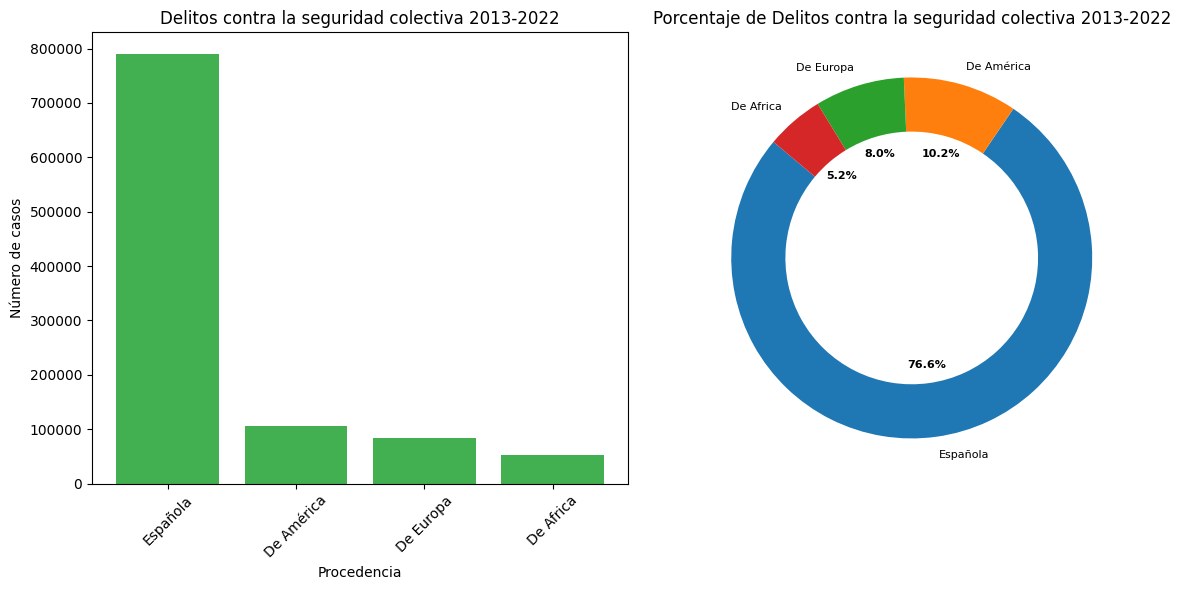

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(seguridad_colectiva_general["nacionalidad"], seguridad_colectiva_general["total"], color="#42af50")
axes[0].set_xlabel("Procedencia")
axes[0].set_ylabel("Número de casos")
axes[0].set_title("Delitos contra la seguridad colectiva 2013-2022")
axes[0].tick_params(axis='x', rotation=45)

seguridad_colectiva_general["porcentaje"] = round(seguridad_colectiva_general["total"] / seguridad_colectiva_general["total"].sum() * 100, 2)

wedges, texts, autotexts = axes[1].pie(seguridad_colectiva_general["porcentaje"], labels=seguridad_colectiva_general["nacionalidad"], 
                                       autopct="%1.1f%%", startangle=140, wedgeprops=dict(width=0.3))
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)
axes[1].set_title("Porcentaje de Delitos contra la seguridad colectiva 2013-2022")

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Evolution in the last 10 years</h3>

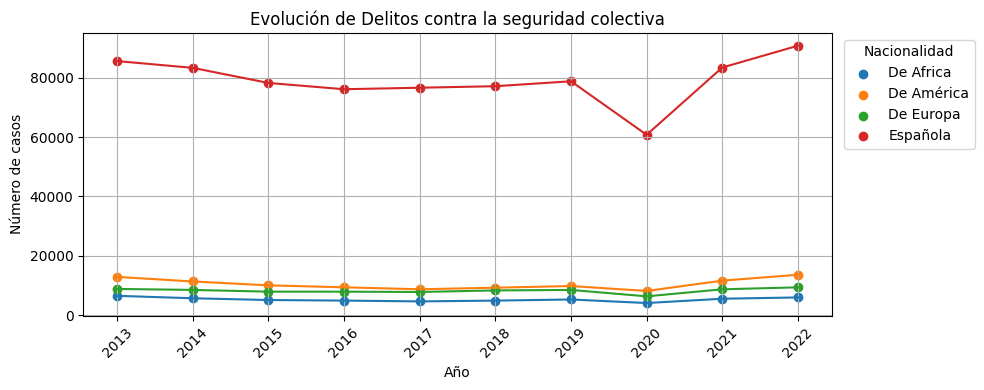

In [48]:
plt.figure(figsize=(10,4))

for i, nacionalidad in enumerate(nacionalidades):
    subset = seguridad_colectiva[seguridad_colectiva["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["total"], label= nacionalidad)
    plt.plot(subset["periodo"], subset["total"])
    
plt.xticks(range(2013,2023), rotation= 45)
    
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.title("Evolución de Delitos contra la seguridad colectiva")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Percentage of crime growth by year</h3>

In [49]:
seguridad_colectiva["porcentaje_crecimiento"] = round(seguridad_colectiva.groupby("nacionalidad")["total"].pct_change()*100,2)
seguridad_colectiva["porcentaje_crecimiento"].fillna(0, inplace=True)

In [50]:
# Calculate average percentage growth in the last decade

seguridad_colectiva_avg_pct = seguridad_colectiva.groupby("nacionalidad")["porcentaje_crecimiento"].mean()
seguridad_colectiva_avg_pct

nacionalidad
De Africa     0.173
De América    1.755
De Europa     1.609
Española      1.522
Name: porcentaje_crecimiento, dtype: float64

In [51]:
# Percentage Average Standard deviation

round(seguridad_colectiva_avg_pct.std(), 2)

0.73

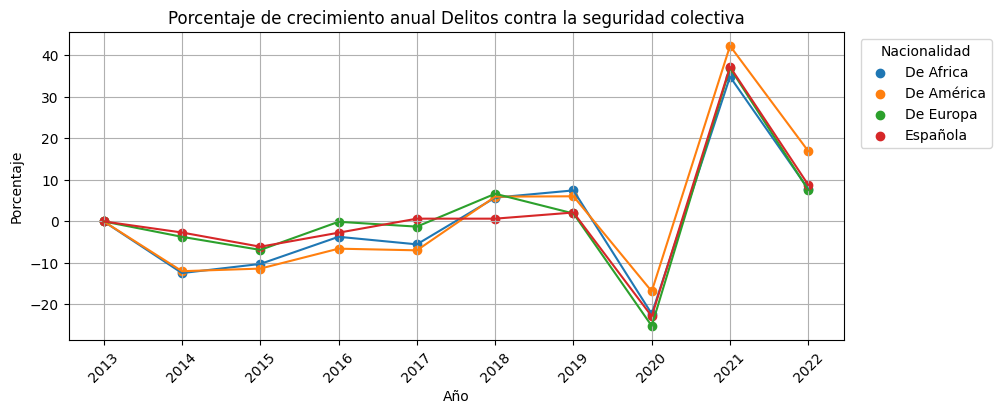

In [52]:
plt.figure(figsize=(10,4))

for nacionalidad in nacionalidades:
    subset = seguridad_colectiva[seguridad_colectiva["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["porcentaje_crecimiento"], marker="o", label= nacionalidad)
    plt.plot(subset["periodo"], subset["porcentaje_crecimiento"])
    
plt.xticks(range(2013,2023), rotation= 45)

plt.xlabel("Año")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de crecimiento anual Delitos contra la seguridad colectiva")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

<h2 style="color: #327a81;">Type: Theft</h2>

<h3 style="color: #60b671;">Decade Numbers and Percetage</h3>

In [53]:
hurtos_general = hurtos.groupby("nacionalidad")["total"].sum().sort_values(ascending=False).reset_index()

In [54]:
hurtos_general

,nacionalidad,total
0,Española,312769
1,De Europa,73221
2,De Africa,40929
3,De América,36139


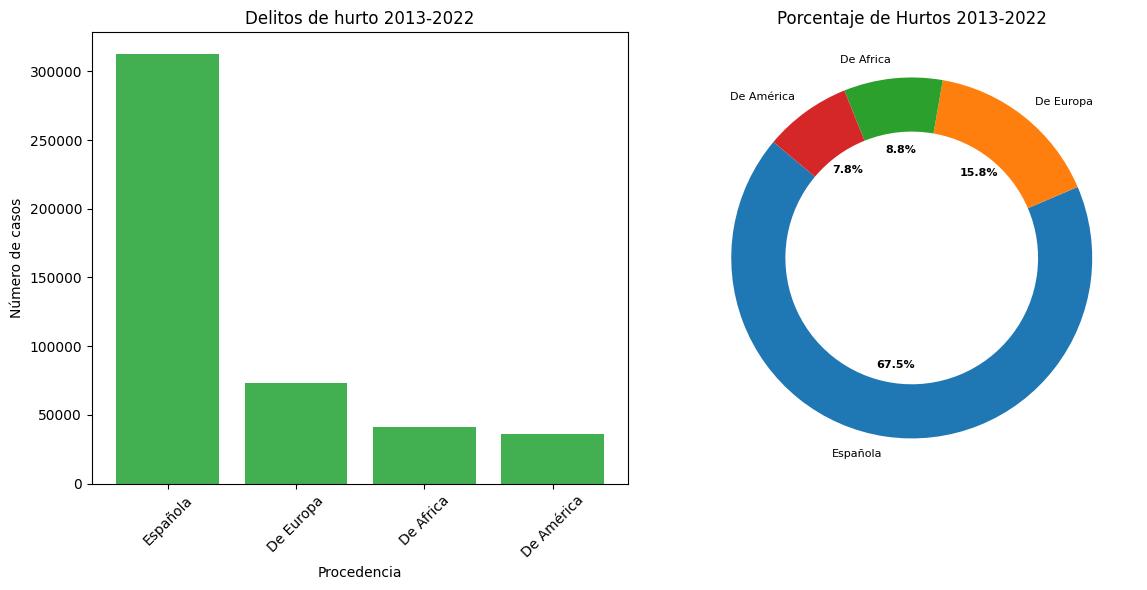

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(hurtos_general["nacionalidad"], hurtos_general["total"], color="#42af50")
axes[0].set_xlabel("Procedencia")
axes[0].set_ylabel("Número de casos")
axes[0].set_title("Delitos de hurto 2013-2022")
axes[0].tick_params(axis='x', rotation=45)

hurtos_general["porcentaje"] = round(hurtos_general["total"] / hurtos_general["total"].sum() * 100, 2)

wedges, texts, autotexts = axes[1].pie(hurtos_general["porcentaje"], labels=hurtos_general["nacionalidad"], 
                                       autopct="%1.1f%%", startangle=140, wedgeprops=dict(width=0.3))
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)
axes[1].set_title("Porcentaje de Hurtos 2013-2022")

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Evolution in the last 10 years</h3>

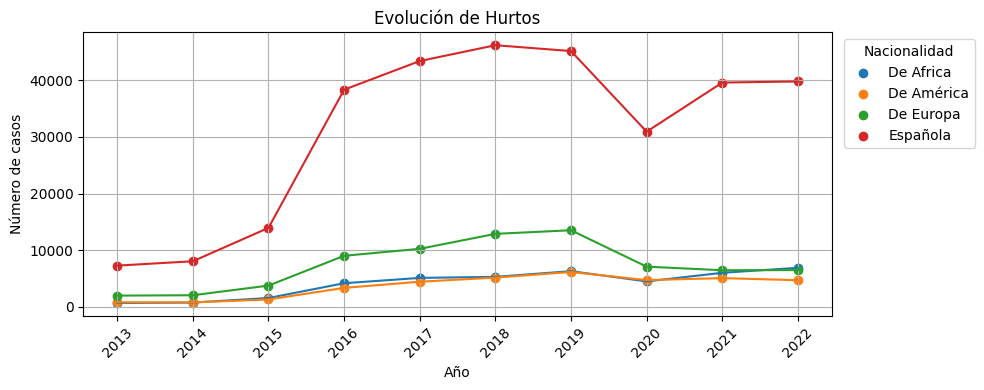

In [56]:
plt.figure(figsize=(10,4))

for i, nacionalidad in enumerate(nacionalidades):
    subset = hurtos[hurtos["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["total"], label= nacionalidad)
    plt.plot(subset["periodo"], subset["total"])
    
plt.xticks(range(2013,2023), rotation= 45)
    
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.title("Evolución de Hurtos")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Percentage of crime growth by year</h3>

In [57]:
hurtos["porcentaje_crecimiento"] = round(hurtos.groupby("nacionalidad")["total"].pct_change()*100,2)
hurtos["porcentaje_crecimiento"].fillna(0, inplace=True)

In [58]:
# Calculate average percentage growth in the last decade

hurtos_avg_pct = hurtos.groupby("nacionalidad")["porcentaje_crecimiento"].mean()
hurtos_avg_pct

nacionalidad
De Africa     36.162
De América    27.446
De Europa     21.816
Española      27.415
Name: porcentaje_crecimiento, dtype: float64

In [59]:
# Percentage Average Standard deviation

round(hurtos_avg_pct.std(), 2)

5.93

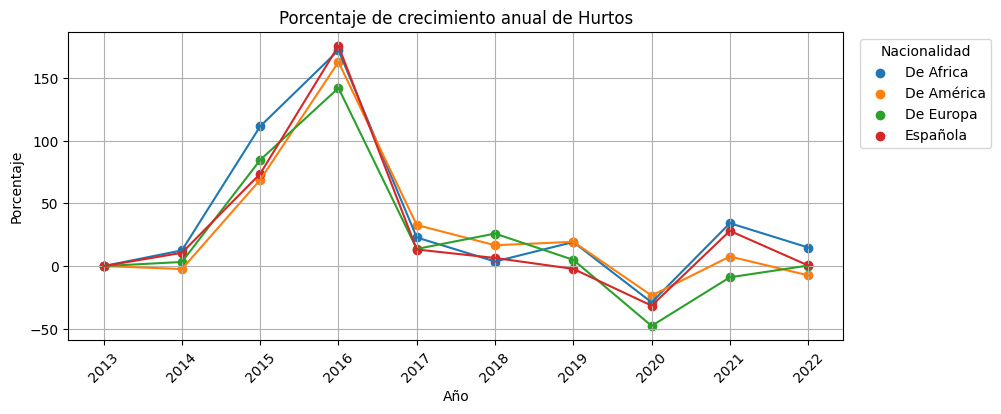

In [60]:
plt.figure(figsize=(10,4))

for nacionalidad in nacionalidades:
    subset = hurtos[hurtos["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["porcentaje_crecimiento"], marker="o", label= nacionalidad)
    plt.plot(subset["periodo"], subset["porcentaje_crecimiento"])
    
plt.xticks(range(2013,2023), rotation= 45)

plt.xlabel("Año")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de crecimiento anual de Hurtos")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

<h2 style="color: #327a81;">Type: Robbery</h2>

<h3 style="color: #60b671;">Decade Numbers and Percetage</h3>

In [61]:
robos_general = robos.groupby("nacionalidad")["total"].sum().sort_values(ascending=False).reset_index()

In [62]:
robos_general

,nacionalidad,total
0,Española,193977
1,De Africa,29677
2,De Europa,25060
3,De América,11159


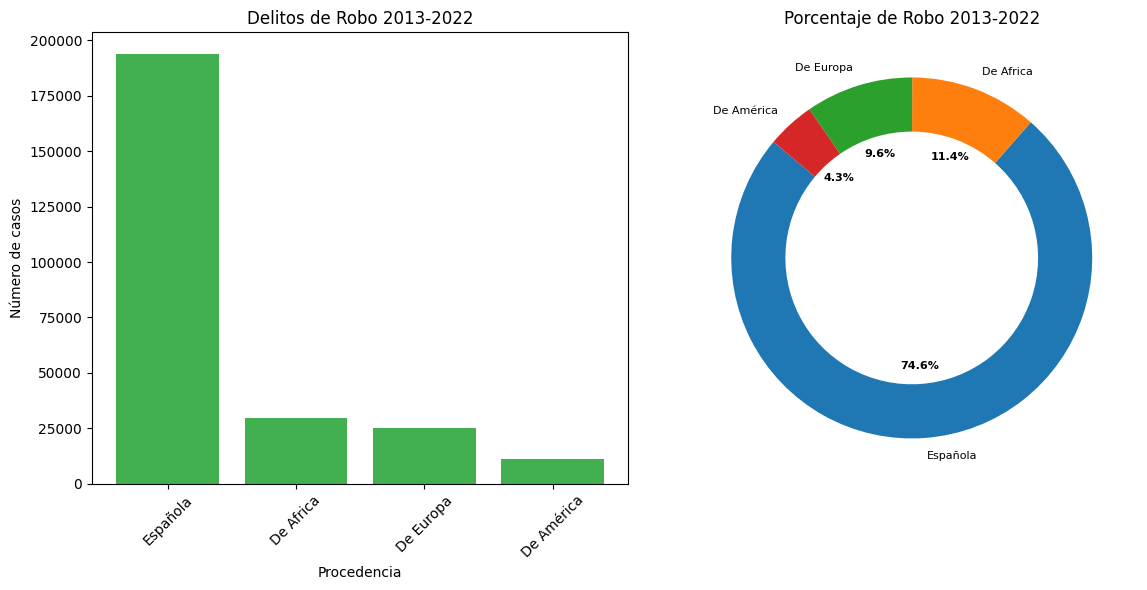

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(robos_general["nacionalidad"], robos_general["total"], color="#42af50")
axes[0].set_xlabel("Procedencia")
axes[0].set_ylabel("Número de casos")
axes[0].set_title("Delitos de Robo 2013-2022")
axes[0].tick_params(axis='x', rotation=45)

robos_general["porcentaje"] = round(robos_general["total"] / robos_general["total"].sum() * 100, 2)

wedges, texts, autotexts = axes[1].pie(robos_general["porcentaje"], labels=robos_general["nacionalidad"], 
                                       autopct="%1.1f%%", startangle=140, wedgeprops=dict(width=0.3))
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)
axes[1].set_title("Porcentaje de Robo 2013-2022")

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Evolution in the last 10 years</h3>

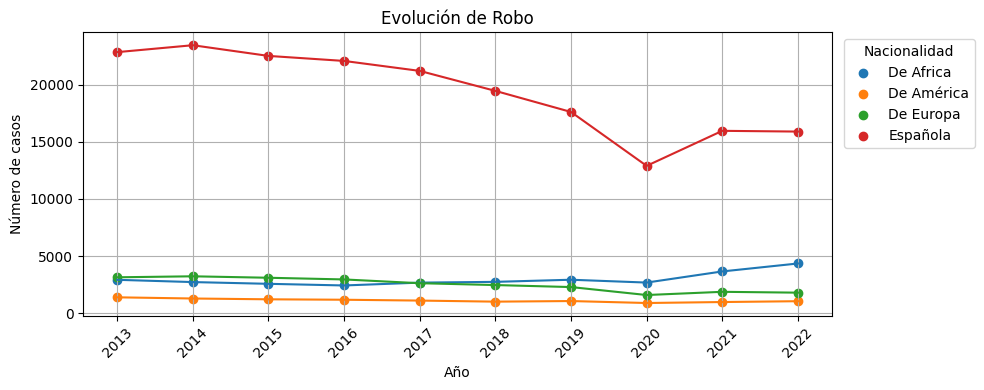

In [64]:
plt.figure(figsize=(10,4))

for i, nacionalidad in enumerate(nacionalidades):
    subset = robos[robos["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["total"], label= nacionalidad)
    plt.plot(subset["periodo"], subset["total"])
    
plt.xticks(range(2013,2023), rotation= 45)
    
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.title("Evolución de Robo")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Percentage of crime growth by year</h3>

In [65]:
robos["porcentaje_crecimiento"] = round(robos.groupby("nacionalidad")["total"].pct_change()*100,2)
robos["porcentaje_crecimiento"].fillna(0, inplace=True)

In [66]:
# Calculate average percentage growth in the last decade

robos_avg_pct = robos.groupby("nacionalidad")["porcentaje_crecimiento"].mean()
robos_avg_pct

nacionalidad
De Africa     4.846
De América   -2.469
De Europa    -4.716
Española     -2.839
Name: porcentaje_crecimiento, dtype: float64

In [67]:
# Percentage Average Standard deviation

round(robos_avg_pct.std(), 2)

4.21

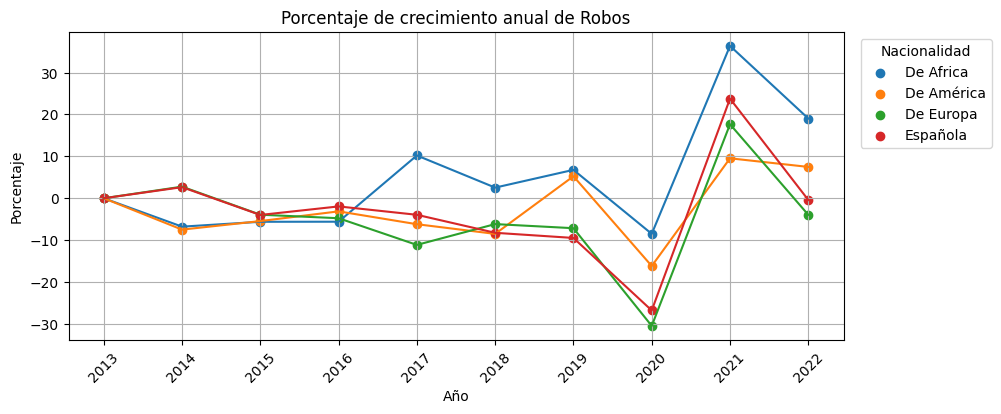

In [68]:
plt.figure(figsize=(10,4))

for nacionalidad in nacionalidades:
    subset = robos[robos["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["porcentaje_crecimiento"], marker="o", label= nacionalidad)
    plt.plot(subset["periodo"], subset["porcentaje_crecimiento"])
    
plt.xticks(range(2013,2023), rotation= 45)

plt.xlabel("Año")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de crecimiento anual de Robos")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

<h2 style="color: #327a81;">Type: Injuries</h2>

<h3 style="color: #60b671;">Decade Numbers and Percetage</h3>

In [69]:
lesiones_general = lesiones.groupby("nacionalidad")["total"].sum().sort_values(ascending=False).reset_index()

In [70]:
lesiones_general

,nacionalidad,total
0,Española,419302
1,De América,48767
2,De Europa,43287
3,De Africa,42925


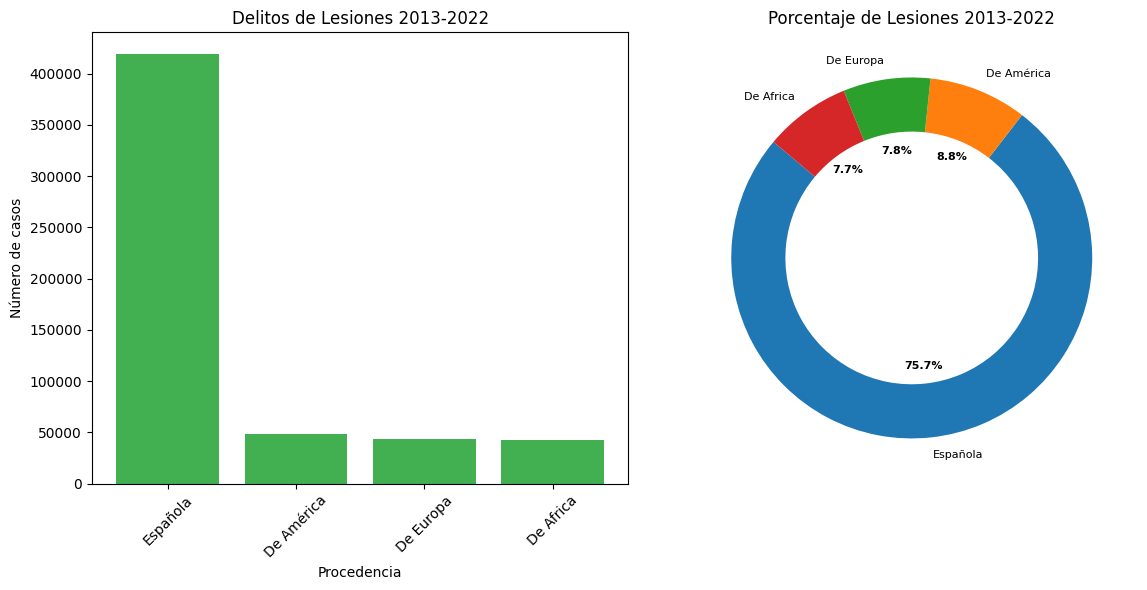

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(lesiones_general["nacionalidad"], lesiones_general["total"], color="#42af50")
axes[0].set_xlabel("Procedencia")
axes[0].set_ylabel("Número de casos")
axes[0].set_title("Delitos de Lesiones 2013-2022")
axes[0].tick_params(axis='x', rotation=45)

lesiones_general["porcentaje"] = round(lesiones_general["total"] / lesiones_general["total"].sum() * 100, 2)

wedges, texts, autotexts = axes[1].pie(lesiones_general["porcentaje"], labels=lesiones_general["nacionalidad"], 
                                       autopct="%1.1f%%", startangle=140, wedgeprops=dict(width=0.3))
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)
axes[1].set_title("Porcentaje de Lesiones 2013-2022")

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Evolution in the last 10 years</h3>

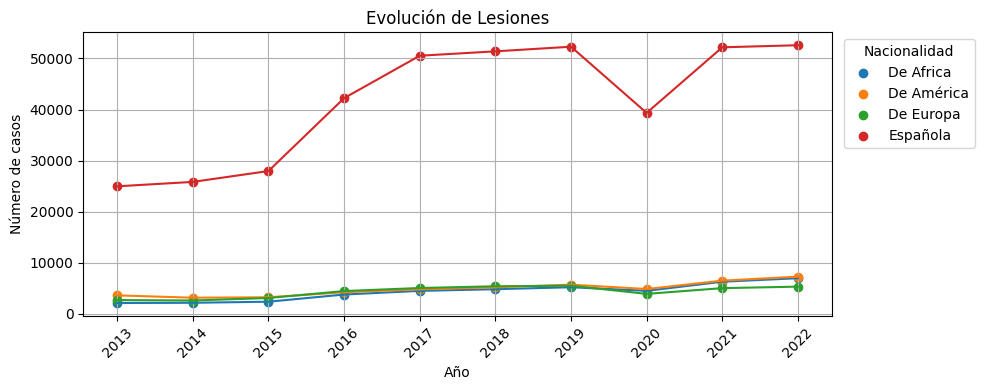

In [72]:
plt.figure(figsize=(10,4))

for i, nacionalidad in enumerate(nacionalidades):
    subset = lesiones[lesiones["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["total"], label= nacionalidad)
    plt.plot(subset["periodo"], subset["total"])
    
plt.xticks(range(2013,2023), rotation= 45)
    
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.title("Evolución de Lesiones")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Percentage of crime growth by year</h3>

In [73]:
lesiones["porcentaje_crecimiento"] = round(lesiones.groupby("nacionalidad")["total"].pct_change()*100,2)
lesiones["porcentaje_crecimiento"].fillna(0, inplace=True)

In [74]:
# Calculate average percentage growth in the last decade

lesiones_avg_pct = lesiones.groupby("nacionalidad")["porcentaje_crecimiento"].mean()
lesiones_avg_pct

nacionalidad
De Africa     14.115
De América     8.254
De Europa      8.666
Española       9.444
Name: porcentaje_crecimiento, dtype: float64

In [75]:
# Percentage Average Standard deviation

round(lesiones_avg_pct.std(), 2)

2.71

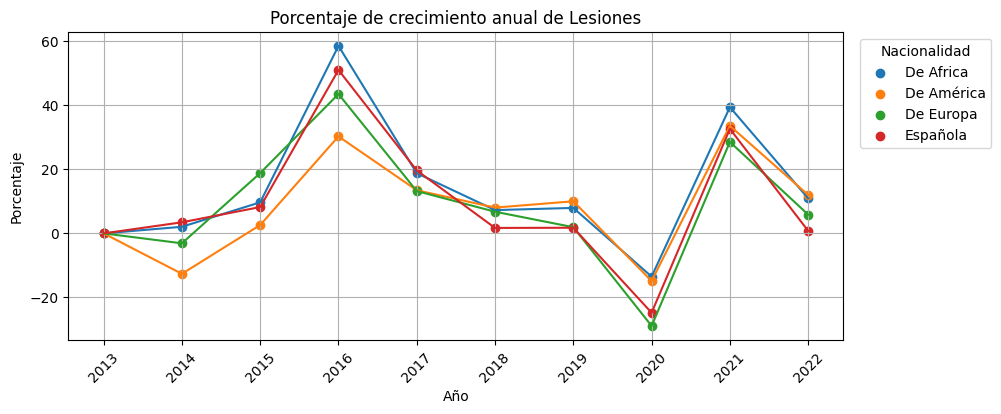

In [76]:
plt.figure(figsize=(10,4))

for nacionalidad in nacionalidades:
    subset = lesiones[lesiones["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["porcentaje_crecimiento"], marker="o", label= nacionalidad)
    plt.plot(subset["periodo"], subset["porcentaje_crecimiento"])
    
plt.xticks(range(2013,2023), rotation= 45)

plt.xlabel("Año")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de crecimiento anual de Lesiones")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

<h2 style="color: #327a81;">Type: Damages</h2>

<h3 style="color: #60b671;">Decade Numbers and Percetage</h3>

In [77]:
daños_general = daños.groupby("nacionalidad")["total"].sum().sort_values(ascending=False).reset_index()

In [78]:
daños_general

,nacionalidad,total
0,Española,65499
1,De Europa,5640
2,De Africa,4812
3,De América,4016


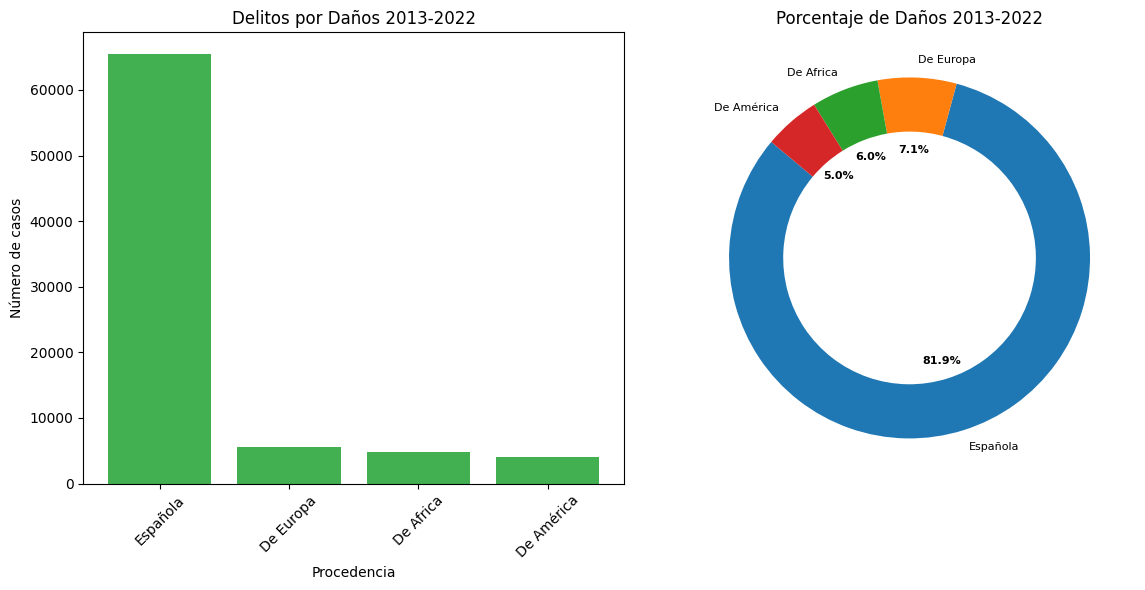

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(daños_general["nacionalidad"], daños_general["total"], color="#42af50")
axes[0].set_xlabel("Procedencia")
axes[0].set_ylabel("Número de casos")
axes[0].set_title("Delitos por Daños 2013-2022")
axes[0].tick_params(axis='x', rotation=45)

daños_general["porcentaje"] = round(daños_general["total"] / daños_general["total"].sum() * 100, 2)

wedges, texts, autotexts = axes[1].pie(daños_general["porcentaje"], labels=daños_general["nacionalidad"], 
                                       autopct="%1.1f%%", startangle=140, wedgeprops=dict(width=0.3))
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)
axes[1].set_title("Porcentaje de Daños 2013-2022")

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Evolution in the last 10 years</h3>

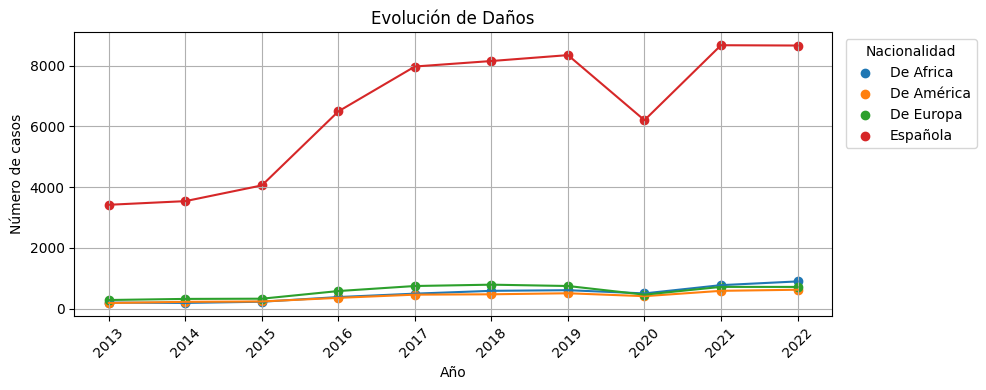

In [80]:
plt.figure(figsize=(10,4))

for i, nacionalidad in enumerate(nacionalidades):
    subset = daños[daños["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["total"], label= nacionalidad)
    plt.plot(subset["periodo"], subset["total"])
    
plt.xticks(range(2013,2023), rotation= 45)
    
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.title("Evolución de Daños")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Percentage of crime growth by year</h3>

In [81]:
daños["porcentaje_crecimiento"] = round(daños.groupby("nacionalidad")["total"].pct_change()*100,2)
daños["porcentaje_crecimiento"].fillna(0, inplace=True)

In [82]:
# Calculate average percentage growth in the last decade

daños_avg_pct = daños.groupby("nacionalidad")["porcentaje_crecimiento"].mean()
daños_avg_pct

nacionalidad
De Africa     18.962
De América    14.851
De Europa     13.984
Española      11.973
Name: porcentaje_crecimiento, dtype: float64

In [83]:
# Percentage Average Standard deviation

round(daños_avg_pct.std(), 2)

2.94

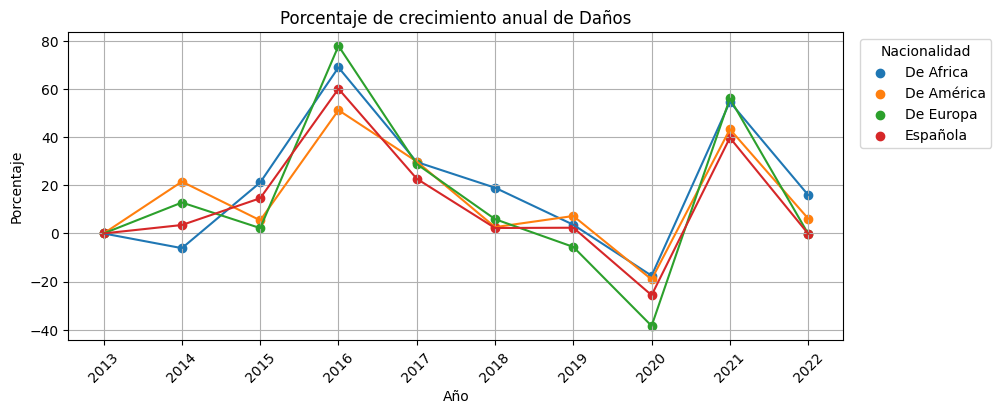

In [84]:
plt.figure(figsize=(10,4))

for nacionalidad in nacionalidades:
    subset = daños[daños["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["porcentaje_crecimiento"], marker="o", label= nacionalidad)
    plt.plot(subset["periodo"], subset["porcentaje_crecimiento"])
    
plt.xticks(range(2013,2023), rotation= 45)

plt.xlabel("Año")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de crecimiento anual de Daños")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

<h2 style="color: #327a81;">Type: Homicidies</h2>

<h3 style="color: #60b671;">Decade Numbers and Percetage</h3>

In [85]:
homicidios_general = homicidios.groupby("nacionalidad")["total"].sum().sort_values(ascending=False).reset_index()

In [86]:
homicidios_general

,nacionalidad,total
0,Española,9278
1,De Europa,997
2,De América,837
3,De Africa,704


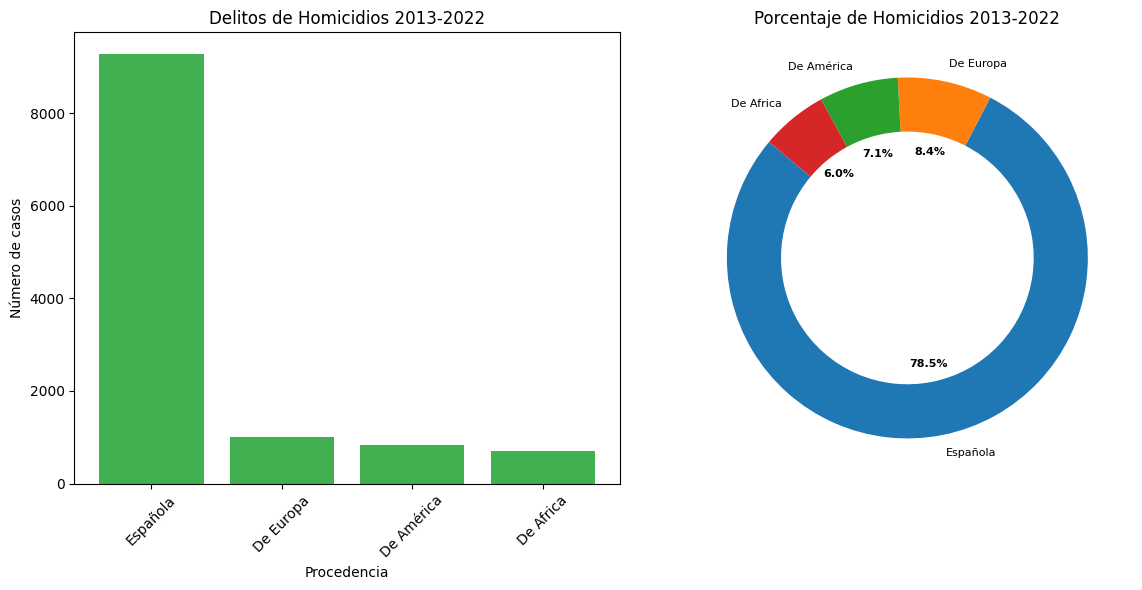

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(homicidios_general["nacionalidad"], homicidios_general["total"], color="#42af50")
axes[0].set_xlabel("Procedencia")
axes[0].set_ylabel("Número de casos")
axes[0].set_title("Delitos de Homicidios 2013-2022")
axes[0].tick_params(axis='x', rotation=45)

homicidios_general["porcentaje"] = round(homicidios_general["total"] / homicidios_general["total"].sum() * 100, 2)

wedges, texts, autotexts = axes[1].pie(homicidios_general["porcentaje"], labels=homicidios_general["nacionalidad"], 
                                       autopct="%1.1f%%", startangle=140, wedgeprops=dict(width=0.3))
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)
axes[1].set_title("Porcentaje de Homicidios 2013-2022")

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Evolution in the last 10 years</h3>

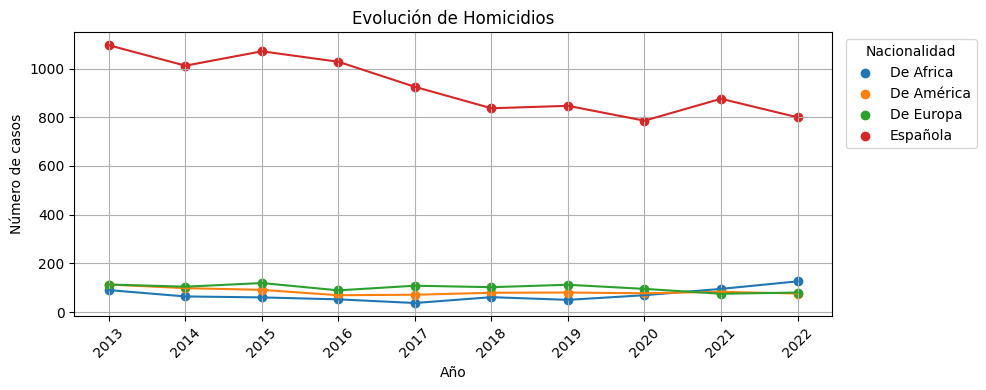

In [88]:
plt.figure(figsize=(10,4))

for i, nacionalidad in enumerate(nacionalidades):
    subset = homicidios[homicidios["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["total"], label= nacionalidad)
    plt.plot(subset["periodo"], subset["total"])
    
plt.xticks(range(2013,2023), rotation= 45)
    
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.title("Evolución de Homicidios")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Percentage of crime growth by year</h3>

In [89]:
homicidios["porcentaje_crecimiento"] = round(homicidios.groupby("nacionalidad")["total"].pct_change()*100,2)
homicidios["porcentaje_crecimiento"].fillna(0, inplace=True)

In [90]:
# Calculate average percentage growth in the last decade

homicidios_avg_pct = homicidios.groupby("nacionalidad")["porcentaje_crecimiento"].mean()
homicidios_avg_pct

nacionalidad
De Africa     7.782
De América   -3.354
De Europa    -2.272
Española     -2.861
Name: porcentaje_crecimiento, dtype: float64

In [91]:
# Percentage Average Standard deviation

round(homicidios_avg_pct.std(), 2)

5.32

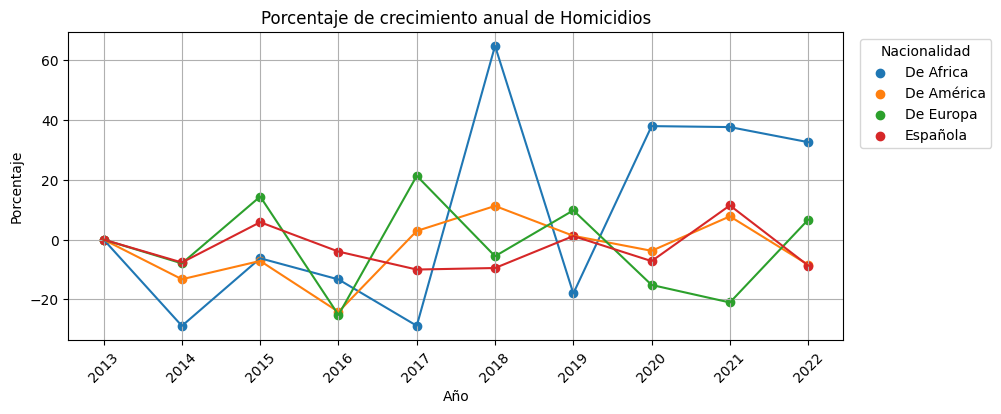

In [92]:
plt.figure(figsize=(10,4))

for nacionalidad in nacionalidades:
    subset = homicidios[homicidios["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["porcentaje_crecimiento"], marker="o", label= nacionalidad)
    plt.plot(subset["periodo"], subset["porcentaje_crecimiento"])
    
plt.xticks(range(2013,2023), rotation= 45)

plt.xlabel("Año")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de crecimiento anual de Homicidios")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

<h2 style="color: #327a81;">[RESUME] Type: All Crime Types in One</h2>

- Before we do the analysis for all crime types, we need to fix the wrong value that we found in "Contra la seguridad colectiva" crime type.
- As we did it before, we will need to replace the cell with the typo. We can use "value_114" variable from the previous work.

In [93]:
df.loc[114, "total"] = value_114

<h3 style="color: #60b671;">Decade Numbers and Percetage</h3>

In [94]:
df_general = df.groupby("nacionalidad")["total"].sum().sort_values(ascending=False).reset_index()

In [95]:
df_general

,nacionalidad,total
0,Española,1894504
1,De Europa,245769
2,De América,218852
3,De Africa,187645


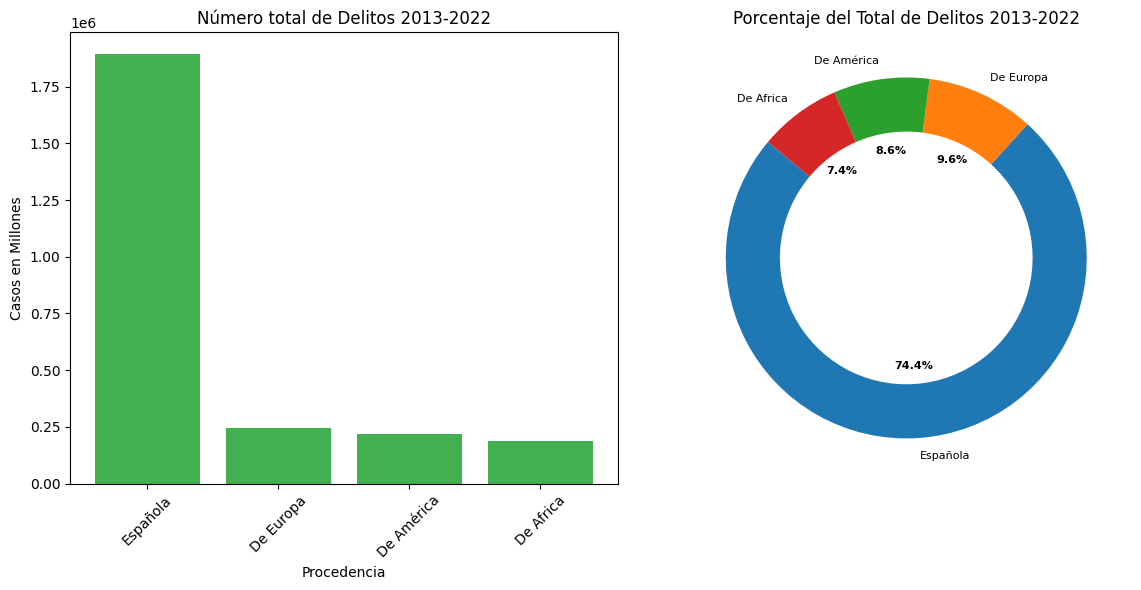

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(df_general["nacionalidad"], df_general["total"], color="#42af50")
axes[0].set_xlabel("Procedencia")
axes[0].set_ylabel("Casos en Millones")
axes[0].set_title("Número total de Delitos 2013-2022")
axes[0].tick_params(axis='x', rotation=45)

df_general["porcentaje"] = round(df_general["total"] / df_general["total"].sum() * 100, 2)

wedges, texts, autotexts = axes[1].pie(df_general["porcentaje"], labels=homicidios_general["nacionalidad"], 
                                       autopct="%1.1f%%", startangle=140, wedgeprops=dict(width=0.3))
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)
axes[1].set_title("Porcentaje del Total de Delitos 2013-2022")

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Evolution in the last 10 years</h3>

In [97]:
df_10years = df.groupby(["nacionalidad","periodo"])["total"].sum()

In [98]:
df_10years = df_10years.reset_index()

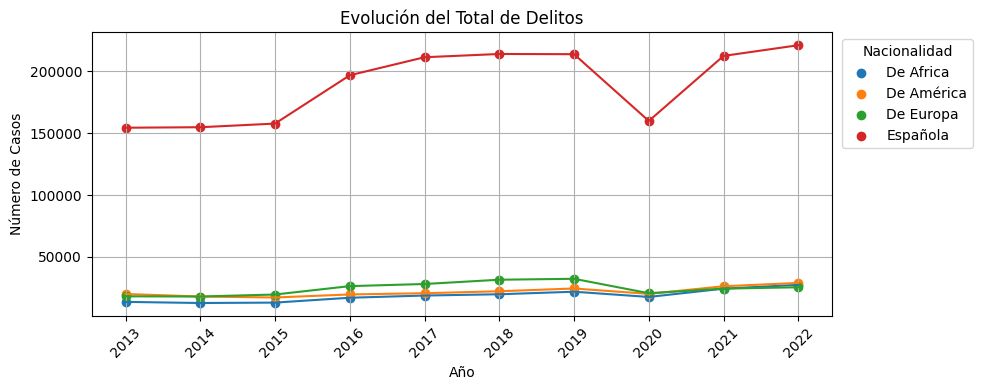

In [99]:
plt.figure(figsize=(10,4))

for i, nacionalidad in enumerate(nacionalidades):
    subset = df_10years[df_10years["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["total"], label= nacionalidad)
    plt.plot(subset["periodo"], subset["total"])
    
plt.xticks(range(2013,2023), rotation= 45)
    
plt.xlabel("Año")
plt.ylabel("Número de Casos")
plt.title("Evolución del Total de Delitos")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Percentage of crime growth by year</h3>

In [100]:
df_10years["porcentaje_crecimiento"] = round(df_10years.groupby("nacionalidad")["total"].pct_change()*100,2)
df_10years["porcentaje_crecimiento"].fillna(0, inplace=True)

In [101]:
# Calculate average percentage growth in the last decade

df_10years_avg_pct = df_10years.groupby("nacionalidad")["porcentaje_crecimiento"].mean()
df_10years_avg_pct

nacionalidad
De Africa     8.297
De América    4.523
De Europa     4.985
Española      4.714
Name: porcentaje_crecimiento, dtype: float64

In [102]:
# Percentage Average Standard deviation

round(df_10years_avg_pct.std(), 2)

1.79

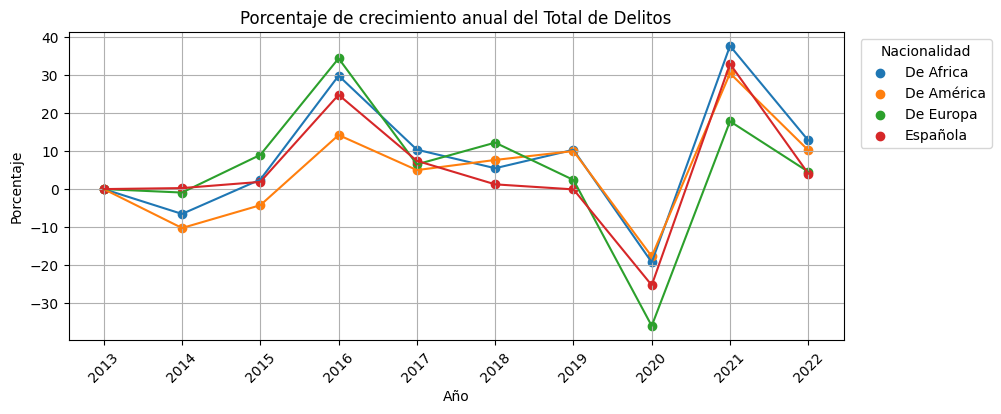

In [103]:
plt.figure(figsize=(10,4))

for nacionalidad in nacionalidades:
    subset = df_10years[df_10years["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["porcentaje_crecimiento"], marker="o", label= nacionalidad)
    plt.plot(subset["periodo"], subset["porcentaje_crecimiento"])
    
plt.xticks(range(2013,2023), rotation= 45)

plt.xlabel("Año")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de crecimiento anual del Total de Delitos")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

<h1 style="color: #492c68;">03 | EDA: Correlation between Crime and Origin</h1>

<h2 style="color: #327a81;">Correlation: General Total Crimes per year v Total Crimes by Origin per Year</h2>

<h3 style="color: #60b671;">Total Crimes per year</h3>

In [104]:
anual_crimes = df.groupby("periodo")["total"].sum().reset_index()

In [105]:
anual_crimes

,periodo,total
0,2013,206499
1,2014,203777
2,2015,207888
3,2016,260022
4,2017,279059
5,2018,287735
6,2019,292619
7,2020,218546
8,2021,287540
9,2022,303085


<h3 style="color: #60b671;">Total Crimes by origin per year</h3>

In [106]:
anual_crimes_by_origin = df.groupby(["nacionalidad","periodo"])["total"].sum().reset_index()

In [107]:
anual_crimes_by_origin = anual_crimes_by_origin.pivot(index="periodo", columns="nacionalidad", values="total").reset_index()

In [108]:
anual_crimes_by_origin

nacionalidad,periodo,De Africa,De América,De Europa,Española
0,2013,13783,20158,18274,154284
1,2014,12884,18098,18108,154687
2,2015,13206,17333,19734,157615
3,2016,17135,19791,26500,196596
4,2017,18907,20776,28221,211155
5,2018,19942,22363,31662,213768
6,2019,21998,24594,32420,213607
7,2020,17772,20249,20782,159743
8,2021,24449,26400,24478,212213
9,2022,27569,29090,25590,220836


<h3 style="color: #60b671;">General Annual Increase</h3>

In [109]:
anual_crimes["incremento_anual"] = anual_crimes["total"].diff()

In [110]:
anual_crimes

,periodo,total,incremento_anual
0,2013,206499,NaN
1,2014,203777,-2722.0
2,2015,207888,4111.0
3,2016,260022,52134.0
4,2017,279059,19037.0
5,2018,287735,8676.0
6,2019,292619,4884.0
7,2020,218546,-74073.0
8,2021,287540,68994.0
9,2022,303085,15545.0


<h3 style="color: #60b671;">Annual Increase by Origin</h3>

In [111]:
anual_origin_increase = anual_crimes_by_origin.diff()

In [112]:
anual_origin_increase

nacionalidad,periodo,De Africa,De América,De Europa,Española
0,NaN,NaN,NaN,NaN,NaN
1,1.0,-899.0,-2060.0,-166.0,403.0
2,1.0,322.0,-765.0,1626.0,2928.0
3,1.0,3929.0,2458.0,6766.0,38981.0
4,1.0,1772.0,985.0,1721.0,14559.0
5,1.0,1035.0,1587.0,3441.0,2613.0
6,1.0,2056.0,2231.0,758.0,-161.0
7,1.0,-4226.0,-4345.0,-11638.0,-53864.0
8,1.0,6677.0,6151.0,3696.0,52470.0
9,1.0,3120.0,2690.0,1112.0,8623.0


<h3 style="color: #60b671;">Correlation between General Increase and Increase by Origins</h3>

In [113]:
correlations = {}

for origin in anual_origin_increase[1:]:
    if origin != "periodo":
        correlation = anual_crimes["incremento_anual"].corr(anual_origin_increase[origin])
        correlations[origin] = correlation

In [114]:
correlations

{'De Africa': 0.9549613336373197,
 'De América': 0.8925395215871899,
 'De Europa': 0.9129550442482901,
 'Española': 0.9968813654699978}

<h3 style="color: #60b671;">Correlation Heatmap</h3>

In [115]:
anual_origin_increase["Total"] = anual_crimes["incremento_anual"]

In [116]:
anual_origin_increase.drop(columns="periodo", inplace=True)

In [117]:
anual_origin_increase

nacionalidad,De Africa,De América,De Europa,Española,Total
0,NaN,NaN,NaN,NaN,NaN
1,-899.0,-2060.0,-166.0,403.0,-2722.0
2,322.0,-765.0,1626.0,2928.0,4111.0
3,3929.0,2458.0,6766.0,38981.0,52134.0
4,1772.0,985.0,1721.0,14559.0,19037.0
5,1035.0,1587.0,3441.0,2613.0,8676.0
6,2056.0,2231.0,758.0,-161.0,4884.0
7,-4226.0,-4345.0,-11638.0,-53864.0,-74073.0
8,6677.0,6151.0,3696.0,52470.0,68994.0
9,3120.0,2690.0,1112.0,8623.0,15545.0


In [118]:
anual_crime_corr = anual_origin_increase.corr()

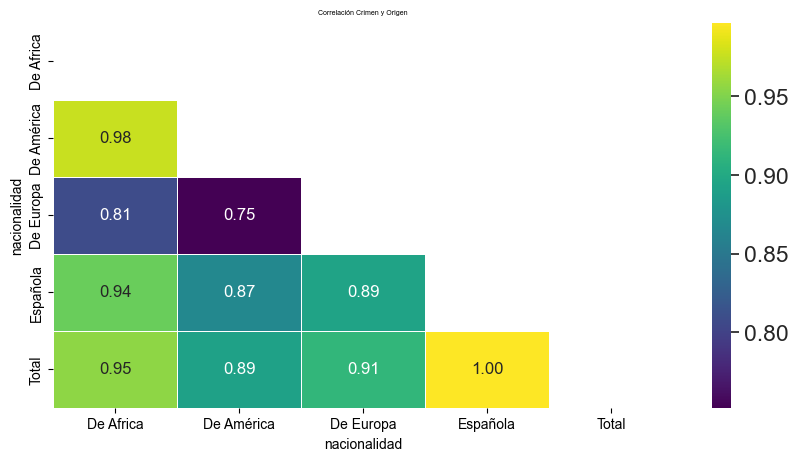

In [119]:
mask = np.zeros_like(anual_crime_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(10, 5))
sns.set(font_scale=1.5) # increase font size

ax = sns.heatmap(anual_crime_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="viridis", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlación Crimen y Origen", fontsize=5) # add title
plt.show()

<h1 style="color: #492c68;">04 | Export CSV for Power Bi Dashboard</h1>

In [120]:
df_10years.to_csv("total_crimes_10y.csv", index=False)